# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [29]:
import eli5
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

##### Task Statement:
<i> There are many factors affects a car's price, such as its production year, manufacturer, model etc. Shared vehicles dataset is containing 17 features including cars' VIN, region & state information of 426880 cars. The goal of this task is to detirmine which one(s) of these features is more imporantant, when setting a car's price. </i>

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
df = pd.read_csv('data/vehicles.csv')
df.shape

(426880, 18)

In [3]:
df['age'] = 2022 - df['year'] # to see year's correlations more clear

In [4]:
df.describe(include = 'all')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,age
count,"426,880.00",426880,"426,880.00","425,675.00",409234,421603,252776,249202,423867,"422,480.00",418638,424324,265838,296313,120519,334022,296677,426880,"425,675.00"
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51,NaN
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca,NaN
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614,NaN
mean,"7,311,486,634.22",NaN,"75,199.03","2,011.24",NaN,NaN,NaN,NaN,NaN,"98,043.33",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.76
std,"4,473,170.41",NaN,"12,182,282.17",9.45,NaN,NaN,NaN,NaN,NaN,"213,881.50",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.45
min,"7,207,408,119.00",NaN,0.00,"1,900.00",NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
25%,"7,308,143,339.25",NaN,"5,900.00","2,008.00",NaN,NaN,NaN,NaN,NaN,"37,704.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00
50%,"7,312,620,821.00",NaN,"13,950.00","2,013.00",NaN,NaN,NaN,NaN,NaN,"85,548.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.00
75%,"7,315,253,543.50",NaN,"26,485.75","2,017.00",NaN,NaN,NaN,NaN,NaN,"133,542.50",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.00


In [5]:
print(df.id.nunique() == df.shape[0])
print(df.VIN.nunique() == df.shape[0])

# Since VIN is unique code, I think that id is given by dataset.
# So, I believe that VIN is more reliable, while eliminating duplicates.

True
False


In [6]:
df[['age', 'price', 'odometer']].corr()

,age,price,odometer
age,1.00,0.00,0.16
price,0.00,1.00,0.01
odometer,0.16,0.01,1.00


#### Insights (1):
<br>
<li> Older cars are slightly cheaper than new ones. (age - price) </li>
<li> Older cars are used more. (age - odometer) </li>
<li> The more the car is used, the more expensive it gets. (odometer - price) </li>

In [7]:
for col in ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']:
    counts = df[col].value_counts()
    perc = df[col].value_counts(normalize = True).mul(100).round(1).astype(str) + '%'
    nas = df[col].isna().sum()
    print(col)
    print(((df[col].isna().sum() / df.shape[0]).round(2)*100).astype(str).split('.')[0], '% of the columns is na')
    print(pd.DataFrame({'count': counts, 'percentage': perc}), '\n\n')

manufacturer
4 % of the columns is na
                 count percentage
ford             70985      17.3%
chevrolet        55064      13.5%
toyota           34202       8.4%
honda            21269       5.2%
nissan           19067       4.7%
jeep             19014       4.6%
ram              18342       4.5%
gmc              16785       4.1%
bmw              14699       3.6%
dodge            13707       3.3%
mercedes-benz    11817       2.9%
hyundai          10338       2.5%
subaru            9495       2.3%
volkswagen        9345       2.3%
kia               8457       2.1%
lexus             8200       2.0%
audi              7573       1.9%
cadillac          6953       1.7%
chrysler          6031       1.5%
acura             5978       1.5%
buick             5501       1.3%
mazda             5427       1.3%
infiniti          4802       1.2%
lincoln           4220       1.0%
volvo             3374       0.8%
mitsubishi        3292       0.8%
mini              2376       0.6%
pontiac   

#### Insights (2):
<br>
<li> Majority of the cars are manufactured by ford or chevrolet. </li>
<li> We don't know condition of 41% of the cars. Among the condition-known cars, almost half of them are in good or excellent shape. </li>
<li> We don't know cyclinder counts of 42% of the cars. Among the cylinder count-known cars, most of them has 4 or 6 cylinders. </li>
<li> Great majority of the cars's fuel is gas. </li>
<li> Almost every car is stated as clean. (title_status) </li>
<li> Majority of the cars have automatic trasmission. </li>
<li> We don't know drive type of 31% of the cars. Among the drive type-known cars, close to half of them are 4 wheel drive. </li>
<li> We don't know most of the cars' size. In known ones, one of two is full size. </li>
<li> We don't know type of 22% of the cars. Among type-known cars, sedan and SUV are common. </li>
<li> We don't know the color of 31% of the cars. Among color-known cars, white and black are common. </li>

0 % of the columns is na
For more clear histogram, 4303 rows with price bigger than 66995 ignored.


<AxesSubplot:>

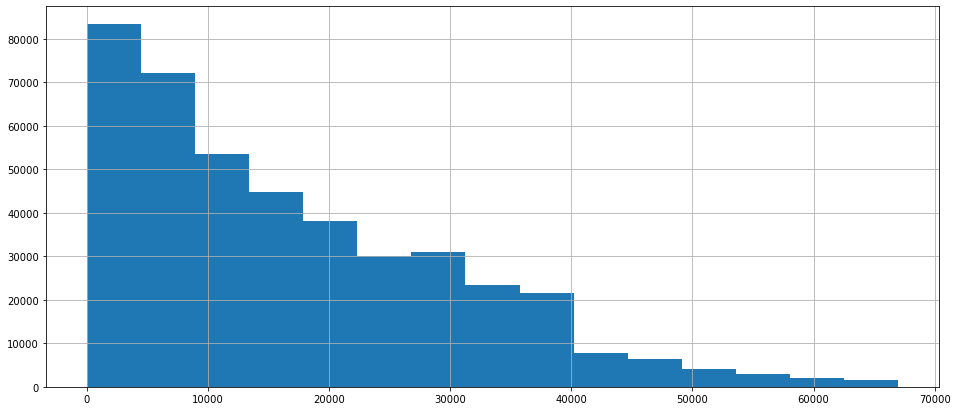

In [8]:
print(((df['price'].isna().sum() / df.shape[0]).round(2)*100).astype(str).split('.')[0], '% of the columns is na')
print('For more clear histogram,', df[df.price >= df.price.quantile(0.99)].shape[0], 'rows with price bigger than', df[df.price >= df.price.quantile(0.99)].price.min(), 'ignored.')
df[df.price < df.price.quantile(0.99)].price.hist(bins = 15, figsize = (16,7))

0 % of the columns is na
For more clear histogram, 4448 rows with age bigger than 55.0 ignored.


<AxesSubplot:>

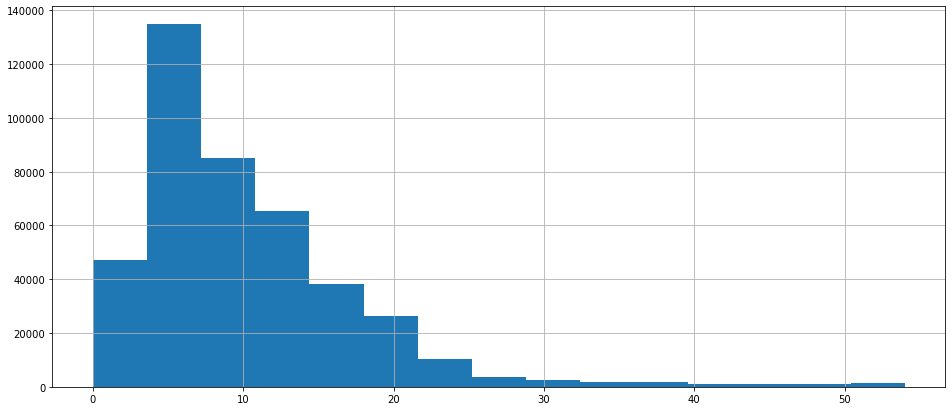

In [9]:
print(((df['age'].isna().sum() / df.shape[0]).round(2)*100).astype(str).split('.')[0], '% of the columns is na')
print('For more clear histogram,', df[df.age >= df.age.quantile(0.99)].shape[0], 'rows with age bigger than', df[df.age >= df.age.quantile(0.99)].age.min(), 'ignored.')
df[df.age < df.age.quantile(0.99)].age.hist(bins = 15, figsize = (16,7))

1 % of the columns is na
For more clear histogram, 0 rows with odometer value bigger than 280000.0 ignored.


<AxesSubplot:>

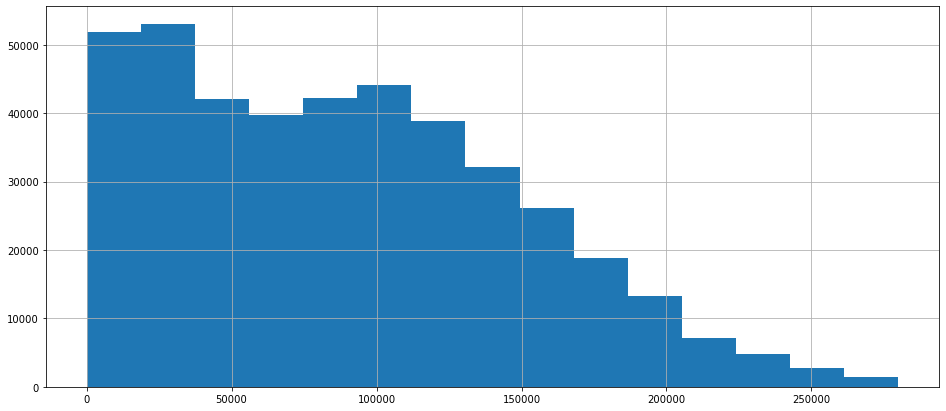

In [10]:
print(((df['odometer'].isna().sum() / df.shape[0]).round(2)*100).astype(str).split('.')[0], '% of the columns is na')
print('For more clear histogram,', df[df.age >= df.odometer.quantile(0.99)].shape[0], 'rows with odometer value bigger than', df[df.odometer >= df.odometer.quantile(0.99)].odometer.min(), 'ignored.')
df[df.odometer < df.odometer.quantile(0.99)].odometer.hist(bins = 15, figsize = (16,7))

#### Insights (3):
<br>
<li> There are more cheap cars than expensive cars. </li>
<li> Most of the cars are younger than 15 years old. </li>
<li> 65% of the cars has odometer value smaller than 50.000. </li>

In [11]:
temp = pd.DataFrame(df.manufacturer.value_counts())
print('Manufacturer column has', df['manufacturer'].nunique(), 'unique values.', temp[temp.manufacturer < 1385].shape[0], 'of them includes less than 0.3% of the data (each).')

Manufacturer column has 42 unique values. 12 of them includes less than 0.3% of the data (each).


In [12]:
temp = pd.DataFrame(df.model.value_counts())
print('Model column has', df['model'].nunique(), 'unique values.', temp[temp.model < 500].shape[0], 'of them has less than 500 rows.')

Model column has 29649 unique values. 29529 of them has less than 500 rows.


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [13]:
# VIN is a better identifier than 'id' column
# with 'age', no need to 'year'
df = df.drop(columns = ['id', 'year']).set_index('VIN')
df.shape

(426880, 16)

#### Missing Handling

In [14]:
# Since 'fuel', 'title_status', 'transmission', 'price', 'age' and 'odometer' has small percentage of nas, dropping 16.138 rows without them.
# Also, 'price' shouldn't be na for the model.
df = df[df.fuel.notna() & df.title_status.notna() & df.transmission.notna() & df.price.notna() & df.age.notna() & df.odometer.notna()]
df.shape

(410742, 16)

In [15]:
# There are 14 features (not counting region & state).
# Thus, if a row has empty values more than half, it is not a good data.
# Therefore, droping 52.843 rows due to lack of features.
df = df[~(df.isna().sum(axis=1) >= 6)]
df.shape

(368276, 16)

In [16]:
# based on information gained from Insights (2), I prefer to fill all nas with 'unknown'.
df = df.fillna('unknown')

#### Handling Duplicates

In [17]:
# To not overfit the model, dropping same rows but one.
df = df.drop_duplicates(keep = 'first')
df.shape

(322734, 16)

#### Handling Minority Values

In [18]:
"""
# based on information gained last cells of Data Understanding, small data of model and manufactured is grouping.
temp = pd.DataFrame(df.manufacturer.value_counts())
df['manufacturer'] = df['manufacturer'].replace(list(temp[temp.manufacturer < 1385].index), 'other')

temp = pd.DataFrame(df.model.value_counts())
df['model'] = df['model'].replace(list(temp[temp.model < 500].index), 'other')
"""

"\n# based on information gained last cells of Data Understanding, small data of model and manufactured is grouping.\ntemp = pd.DataFrame(df.manufacturer.value_counts())\ndf['manufacturer'] = df['manufacturer'].replace(list(temp[temp.manufacturer < 1385].index), 'other')\n\ntemp = pd.DataFrame(df.model.value_counts())\ndf['model'] = df['model'].replace(list(temp[temp.model < 500].index), 'other')\n"

#### Handling Non-Numeric Columns

In [19]:
df['condition'] = df['condition'].map({'excellent': 5,
                                       'new': 4.5, # mean age of new cars' ~9 -- could be false labelling
                                       'good': 4,
                                       'like new':3,
                                       'fair': 2,
                                       'salvage': 1,
                                       'unknown': 0})

df['cylinders'] = df['cylinders'].map({'12 cylinders': 12,
                                       '10 cylinders': 10,
                                       '8 cylinders': 8,
                                       '6 cylinders':6,
                                       '5 cylinders': 5,
                                       '4 cylinders': 4,
                                       '3 cylinders': 3,
                                       'other': 1, # not sure what it means -- more than 12 or less than 3?
                                       'unknown': 1 }) # a car must have at least one cylinder

df['size'] = df['size'].map({'full-size': 4,
                             'mid-size': 3,
                             'compact': 2,
                             'sub-compact': 1,
                             'unknown': 0})

In [20]:
# df['manu_model'] = df['manufacturer'] + df['model']
df = pd.get_dummies(df, columns = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color'])

In [21]:
# 
df.drop(columns = ['region', 'state', 'model'], inplace = True)

#### Spliting

In [22]:
# train - 80%, test - 20%
X = df.drop(columns = ['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
# X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42, shuffle = True)

#### Scaling

In [23]:
X_train_scaled = X_train
X_test_scaled = X_test

scaler = StandardScaler()
X_train_scaled[['odometer', 'age']] = scaler.fit_transform(X_train[['odometer', 'age']])
X_test_scaled[['odometer', 'age']] = scaler.transform(X_test[['odometer', 'age']])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Linear Regression

In [24]:
lr_model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print('MAE:', mean_absolute_error(y_test, lr_model.predict(X_test)))

MAE: 159540.73709080205


#### Ridge

In [25]:
ridge_model = Ridge(alpha=0.1).fit(X_train, y_train)
print('MAE:', mean_absolute_error(y_test, ridge_model.predict(X_test)))

MAE: 159540.38491414193


In [26]:
# GridSearchCV on Ridge's alpha parameter
gscv_ridge_model = GridSearchCV(Ridge(), param_grid = {'alpha': np.linspace(0, 1, 10)}, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose = 3).fit(X_train, y_train)
print('Best Parameters:', gscv_ridge_model.best_params_) 
print('MAE:', mean_absolute_error(y_test, gscv_ridge_model.predict(X_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'alpha': 1.0}
MAE: 159533.57316288978


#### Lasso

In [27]:
lasso_model = Lasso(alpha=0.1).fit(X_train, y_train)
print('MAE:', mean_absolute_error(y_test, lasso_model.predict(X_test)))

MAE: 159538.9916645402


In [28]:
# GridSearchCV on Lasso's alpha parameter
gscv_lasso_model = GridSearchCV(Lasso(), param_grid = {'alpha': np.linspace(0, 1, 10)}, scoring='neg_mean_absolute_error', cv=5, n_jobs=3, verbose = 3).fit(X_train, y_train)
print('Best Parameters:', gscv_lasso_model.best_params_) 
print('MAE:', mean_absolute_error(y_test, gscv_lasso_model.predict(X_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'alpha': 1.0}
MAE: 159520.0516176375


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

<i>
I tried Linear Regression, Ridge and Lasso models with different features combinations. As summary,
    First, I eliminated minorities in model and manufacturer (code commented in Handling with Minorities section). With this version on model and manufacturer:
    <li> Directly turning them into dummies gives <b>MAE: 176248 </b></li>
    <li> Combining them as one column ('manufacturer_model') and using as dummies gives <b>MAE: 171409 </b></li>
    <li> Without manufacturer, just using model column by turning into dummies gives <b>MAE: 161228 </b></li>
    <li> Without model, just using manufacturer column by turning into dummies gives <b>MAE: 159542 </b></li>
    Then, I started to play with variety of model column.
    <li> Increasing 500 limit on model column to 1000 gives <b>MAE: 689727669</b></li>
    <li> Decreasing 500 limit on model column to 300 gives <b>MAE: 172264</b></li>    
    After these, I realized that less number of columns is better for the model. 
    <li> So, as last attempt, I didn't use model column and just go with manufacturer. With this way, <b>MAE: 159538</b></li>
As last step, I run parameter search (on 'alpha') with cv = 5 on both Lasso and Ridge models.
Final model Lasso with alpha = 1 has <b> MAE: 159520</b>
</i>

In [31]:
# checking feature importance of the best model to answer the main question
eli5.show_weights(gscv_lasso_model.best_estimator_, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+580089.655,manufacturer_volvo
+149331.823,type_pickup
+148756.018,manufacturer_toyota
+128926.760,transmission_manual
+118779.693,fuel_diesel
+100526.464,manufacturer_jeep
+98979.139,type_unknown
+98021.220,paint_color_silver
+66629.348,manufacturer_tesla
+64912.858,title_status_clean


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### <i> Summary of Insights: <i>
<p><i>
    <li> Older cars are slightly cheaper than new ones. </li>
    <li> Majority of the cars are manufactured by ford or chevrolet. </li>
    <li> Great majority of the cars's fuel is gas. </li>
    <li> Almost every car is stated as clean. </li>
    <li> Most of the cars are younger than 15 years old. </li>
    <li> 65% of the cars has odometer value smaller than 50.000. </li>
</i>

### <i> Result: <i>
<i> <p> Manufacturer being volvo or toyota, type being pickup, trasmission being manual and diesel as fuel </b> has have strong effect on a car's price, in a positive way. <b> Type being offroad, manufacturer being ram or datsun or harley-davidson </b>, also, have strong effect on a car's price but in a bad way. </i>
<p> <i> A volvo pickup type diesel car with manual transmission can be sold for more. <br> A datsun offroad type hybrid car would sell for lower price. </br> </i>
<p> <b> Thus, we can state that, mostly, car's manufacturer and type drives its price. </b>